In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from scipy import stats

sns.set()

## Data Cleaning


In [13]:
# Because reading in the data returned an error, use the chardet module to detect the encoding used for the data.
with open("takehome_users.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'ISO-8859-1', 'confidence': 0.7294372453287324, 'language': ''}

In [14]:
user_eng = pd.read_csv("takehome_user_engagement.csv")
users = pd.read_csv("takehome_users.csv", encoding="ISO-8859-1")

In [15]:
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [16]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [17]:
# Group the data by user and day to see what it looks like and see if any user logged in more than once a day.
user_eng["time_stamp"] = pd.to_datetime(user_eng["time_stamp"])
grouped_user = user_eng.groupby(["user_id", user_eng["time_stamp"].dt.date]).sum()

grouped_user.describe()

visited
user_id time_stamp         
1       2014-04-22        1
2       2013-11-15        1
        2013-11-29        1
        2013-12-09        1
        2013-12-25        1
...                     ...
11996   2013-09-06        1
11997   2013-01-15        1
11998   2014-04-27        1
11999   2012-06-02        1
12000   2014-01-26        1

[207917 rows x 1 columns]

In [18]:
# Create a cumulative sum of the number of days logged in by each user.
grouped_user["cumulative count"] = grouped_user.groupby(level=0).cumsum()
grouped_user = grouped_user.reset_index()

# Create a shifted value of the 2 log-ins prior.
grouped_user["3 log-ins"] = grouped_user.sort_values(["user_id", "time_stamp"], ascending=True)["time_stamp"].shift(2)
# If the cumulative count of days logged in is less than 2, then set 3 log-ins as NaN.
grouped_user.loc[grouped_user["cumulative count"]<=2, "3 log-ins"] = np.nan

# Create a count of the days between that day's log-in and 2 log-ins prior.
grouped_user["days between"] = grouped_user["time_stamp"] - grouped_user["3 log-ins"]
grouped_user["days between"] = grouped_user["days between"].dt.days

# Create a Series called adopted_user for the users that have a minimum days between value less than or equal to 7.
adopted_user = grouped_user.groupby("user_id")["days between"].apply(lambda x: 1 if x.min() <= 7 else 0).rename("adopted user")

adopted_user

user_id
1        0
2        1
3        0
4        0
5        0
        ..
11996    0
11997    0
11998    0
11999    0
12000    0
Name: adopted user, Length: 8823, dtype: int64

In [98]:
# Join the newly created adopted user series with the users dataframe as these values will be the target feature.
data = users.merge(adopted_user, how="inner", left_on="object_id", right_on="user_id")

# Change the date columns to datetime objects.
data["creation_time"] = pd.to_datetime(data["creation_time"])
data["last_session_creation_time"] = pd.to_datetime(data["last_session_creation_time"], unit="s")

# Create created_month and created_year columns to further observe how adopted user may be affected by the time of creation. 
data["created_month"] = data["creation_time"].dt.month
data["created_year"] = data["creation_time"].dt.year

# Create an email provider column by extracting it from the email.
data["email provider"] = data["email"].str.extract(r"(\@.*\.)", expand=False)\
    .str.replace(r"[@.]", "", regex=True)\
        .str.strip()

other_providers = data["email provider"].value_counts(ascending=False).index[6:]

data["email provider"] = data["email provider"].replace(other_providers, "other")

data

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted user,created_month,created_year,email provider
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,4,2014,yahoo
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,11,2013,gustr
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,3,2013,gustr
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,5,2013,yahoo
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1,2013,yahoo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8818,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,0,9,2013,gustr
8819,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,0,1,2013,gmail
8820,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,0,4,2014,cuvox
8821,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,0,5,2012,other


## Exploratory Data Analysis

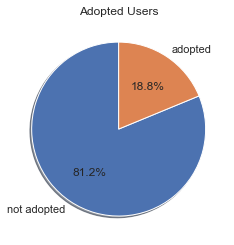

In [133]:
# Visualize the difference between the number of adopted users vs. non-adopted users.

labels = ["not adopted", "adopted"]
sizes = data["adopted user"].value_counts().values

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Adopted Users")
plt.show()

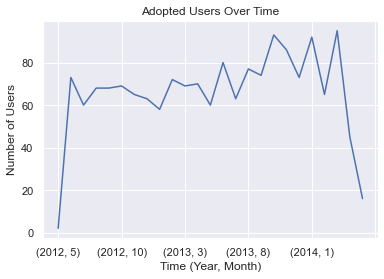

In [145]:
# Visualize the number of adopted users over time.
au_time = data.groupby(["created_year", "created_month"])["adopted user"].sum()

au_time.plot()
plt.title("Adopted Users Over Time")
plt.xlabel("Time (Year, Month)")
plt.ylabel("Number of Users")

plt.show()

In [139]:
# Test for independence for creation_source and adopted users using scipy.
ct = pd.crosstab(data["adopted user"], data["creation_source"], margins=True)
obs = np.array([ct.iloc[0][:5].values, ct.iloc[1][:5].values])
print(f"p-value: {stats.chi2_contingency(obs)[1]:.8f}")
ct/8823

p-value: 0.00000002


creation_source,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,All
adopted user,,,,,,
0,0.138162,0.296271,0.067097,0.180891,0.129888,0.812309
1,0.041823,0.065057,0.019495,0.034229,0.027088,0.187691
All,0.179984,0.361328,0.086592,0.215120,0.156976,1.000000


In [140]:
# Test for independence for created_year and adopted users using scipy.
ct = pd.crosstab(data["adopted user"], data["created_year"], margins=True)
n_cats = len(ct.iloc[0]) - 1
obs = np.array([ct.iloc[0][:n_cats].values, ct.iloc[1][:n_cats].values])
print(f"p-value: {stats.chi2_contingency(obs)[1]:.8f}")
ct/8823

p-value: 0.00000000


created_year,2012,2013,2014,All
adopted user,,,,
0,0.177037,0.373229,0.262042,0.812309
1,0.053043,0.099173,0.035475,0.187691
All,0.230080,0.472402,0.297518,1.000000


In [141]:
# Test for independence for created_month and adopted users using scipy
ct = pd.crosstab(data["adopted user"], data["created_month"], margins=True)
n_cats = len(ct.iloc[0]) - 1
obs = np.array([ct.iloc[0][:n_cats].values, ct.iloc[1][:n_cats].values])
print(f"p-value: {stats.chi2_contingency(obs)[1]:.8f}")
ct/8823

p-value: 0.00000000


created_month,1,2,3,4,5,6,7,8,9,10,11,12,All
adopted user,,,,,,,,,,,,,
0,0.068684,0.065171,0.080585,0.085232,0.109713,0.051230,0.054063,0.056557,0.058257,0.061090,0.059617,0.062110,0.812309
1,0.017001,0.015528,0.018588,0.013034,0.008841,0.017341,0.013941,0.016434,0.016094,0.018361,0.017114,0.015414,0.187691
All,0.085685,0.080698,0.099173,0.098266,0.118554,0.068571,0.068004,0.072991,0.074351,0.079451,0.076731,0.077525,1.000000


In [142]:
# Test for independence for opted_in_to_mailing_list and adopted users using scipy
ct = pd.crosstab(data["adopted user"], data["opted_in_to_mailing_list"], margins=True)
n_cats = len(ct.iloc[0]) - 1
obs = np.array([ct.iloc[0][:n_cats].values, ct.iloc[1][:n_cats].values])
print(f"p-value: {stats.chi2_contingency(obs)[1]:.8f}")
ct/8823

p-value: 0.50180642


opted_in_to_mailing_list,0,1,All
adopted user,,,
0,0.608637,0.203672,0.812309
1,0.139068,0.048623,0.187691
All,0.747705,0.252295,1.000000


In [143]:
# Test for independence for enabled_for_marketing_drip and adopted users using scipy
ct = pd.crosstab(data["adopted user"], data["enabled_for_marketing_drip"], margins=True)
n_cats = len(ct.iloc[0]) - 1
obs = np.array([ct.iloc[0][:n_cats].values, ct.iloc[1][:n_cats].values])
print(f"p-value: {stats.chi2_contingency(obs)[1]:.8f}")
ct/8823

p-value: 0.71511462


enabled_for_marketing_drip,0,1,All
adopted user,,,
0,0.689448,0.122861,0.812309
1,0.158563,0.029128,0.187691
All,0.848011,0.151989,1.000000


In [144]:
# Test for independence for email provider and adopted users using scipy
ct = pd.crosstab(data["adopted user"], data["email provider"], margins=True)
n_cats = len(ct.iloc[0]) - 1
obs = np.array([ct.iloc[0][:n_cats].values, ct.iloc[1][:n_cats].values])
print(f"p-value: {stats.chi2_contingency(obs)[1]:.8f}")
ct/8823

p-value: 0.00000068


email provider,cuvox,gmail,gustr,hotmail,jourrapide,other,yahoo,All
adopted user,,,,,,,,
0,0.077525,0.268956,0.078431,0.067777,0.080812,0.073444,0.165363,0.812309
1,0.016321,0.063130,0.017001,0.023235,0.019268,0.018474,0.030262,0.187691
All,0.093846,0.332087,0.095432,0.091012,0.100079,0.091919,0.195625,1.000000


In [105]:
# See if there are organizations that have many users.
data["org_id"].value_counts(ascending=False)

0      228
1      172
2      150
3      125
4      122
      ... 
396      6
400      6
397      5
386      4
416      2
Name: org_id, Length: 417, dtype: int64